In [1]:
import networkx as nx
from dowhy import gcm
from scipy.stats import truncexpon, halfnorm
import pandas as pd

## Data Generation Process

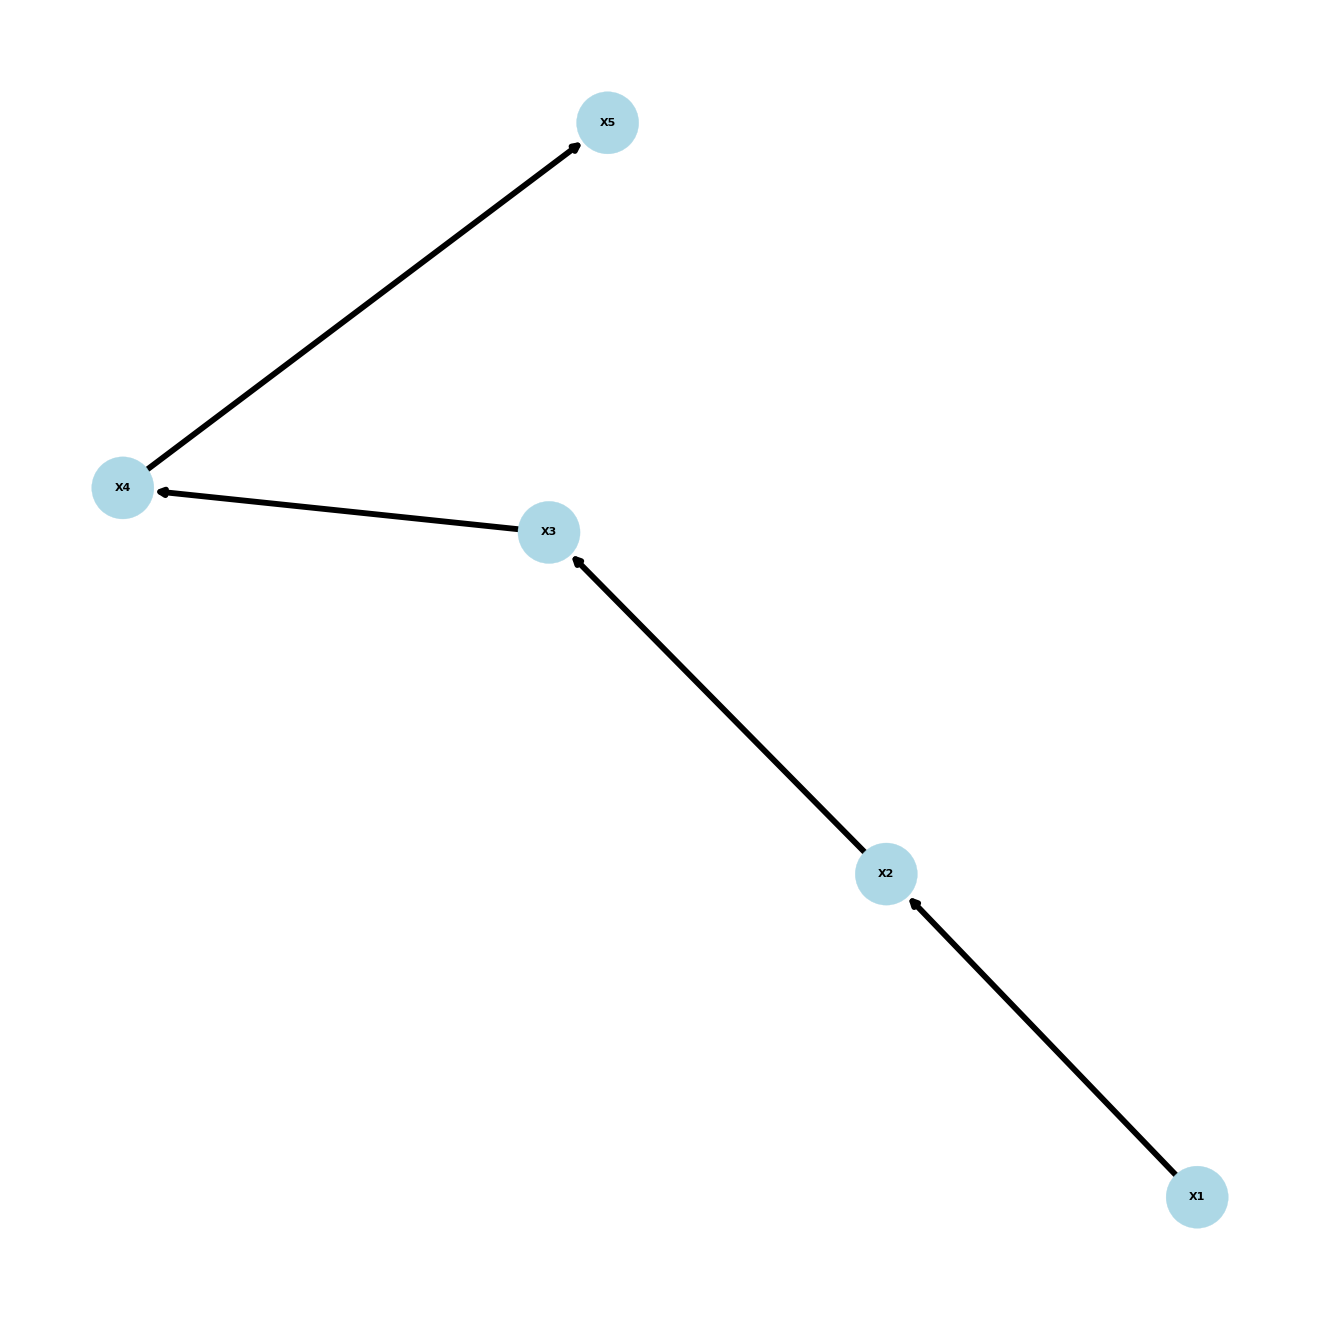

In [2]:
causal_graph = nx.DiGraph([('X1', 'X2'), ('X2', 'X3'), ('X3', 'X4'), ('X4', 'X5')])
gcm.util.plot(causal_graph, figure_size=[13, 13])

In [ ]:
from scipy.stats import truncexpon, halfnorm

def create_observed_latency_data(unobserved_intrinsic_latencies):
    observed_latencies = {}
    observed_latencies['X1'] = unobserved_intrinsic_latencies['X1']
    observed_latencies['X2'] = observed_latencies['X1'] \
                                         + unobserved_intrinsic_latencies['X2']
    observed_latencies['X3'] = observed_latencies['X2'] \
                                         + unobserved_intrinsic_latencies['X3']
    observed_latencies['X4'] = observed_latencies['X3'] \
                                         + unobserved_intrinsic_latencies['X4']
    observed_latencies['X5'] = observed_latencies['X4'] \
                                         + unobserved_intrinsic_latencies['X5']
    return pd.DataFrame(observed_latencies)

In [4]:
def unobserved_intrinsic_latencies_normal(num_samples):
    return {
        'X1': truncexpon.rvs(size=num_samples, b=3, scale=0.2),
        'X2': truncexpon.rvs(size=num_samples, b=2, scale=0.2),
        'X3': halfnorm.rvs(size=num_samples, loc=0.5, scale=0.2),
        'X4': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.2),
        'X5': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.2)
    }

In [5]:
def unobserved_intrinsic_latencies_anomalous(num_samples):
    return {
        'X1': 3 + truncexpon.rvs(size=num_samples, b=3, scale=0.2),
        'X2': truncexpon.rvs(size=num_samples, b=2, scale=0.2),
        'X3': halfnorm.rvs(size=num_samples, loc=0.5, scale=0.2),
        'X4': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.2),
        'X5': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.2)
    }

In [6]:
normal_data = create_observed_latency_data(unobserved_intrinsic_latencies_normal(100))
outlier = create_observed_latency_data(unobserved_intrinsic_latencies_anomalous(1))

In [8]:
normal_data.to_csv('inlier.csv', sep=',', index=False)

In [9]:
outlier.to_csv('outlier.csv', sep=',', index=False)

In [10]:
from scipy.stats import halfnorm

causal_model = gcm.StructuralCausalModel(causal_graph)

for node in causal_graph.nodes:
    if len(list(causal_graph.predecessors(node))) > 0:
        causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    else:
        causal_model.set_causal_mechanism(node, gcm.ScipyDistribution(halfnorm))

In [11]:
gcm.config.disable_progress_bars() # to disable print statements when computing Shapley values

median_attribs, uncertainty_attribs = gcm.confidence_intervals(
    gcm.fit_and_compute(gcm.attribute_anomalies,
                        causal_model,
                        normal_data,
                        target_node='X5',
                        anomaly_samples=outlier),
    num_bootstrap_resamples=1)

we have sampled_data of size (75, 5)
the sampled data is used to fit FCM
causal_model.causal_mechanism(X1) is <dowhy.gcm.stochastic_models.ScipyDistribution object at 0x7fe7433d8df0>
causal_model.causal_mechanism(X2) is AdditiveNoiseModel with SklearnRegressionModel and an InvertibleIdentityFunction
Fitting emperical model
causal_model.causal_mechanism(X3) is AdditiveNoiseModel with SklearnRegressionModel and an InvertibleIdentityFunction
Fitting emperical model
causal_model.causal_mechanism(X4) is AdditiveNoiseModel with SklearnRegressionModel and an InvertibleIdentityFunction
Fitting emperical model
causal_model.causal_mechanism(X5) is AdditiveNoiseModel with SklearnRegressionModel and an InvertibleIdentityFunction
Fitting emperical model
anomaly_scorer is MedianCDFQuantileScorer()
target_node X5
outlier is          X1        X2        X3        X4        X5
0  3.005751  3.110428  3.713904  3.843895  3.984689
its noise is          X1        X2        X3        X4        X5
0  3.00575

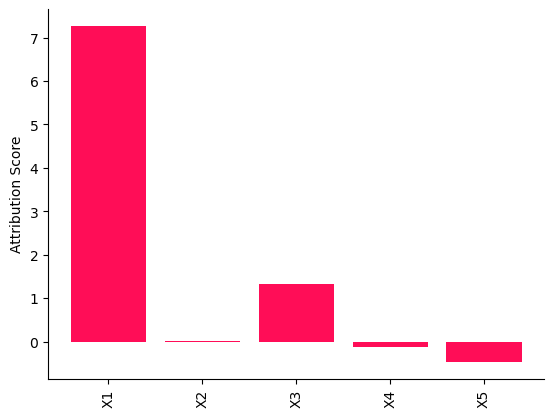

In [12]:
gcm.util.bar_plot(median_attribs, uncertainty_attribs, 'Attribution Score')